### Import Libraries

In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

### Download the Dataset

In [75]:
# def download_dataset():
#     with zipfile.ZipFile('garbage-classification.zip', 'r') as zip_ref:
#         zip_ref.extractall('garbage_classification')

# np.random.seed(42)
# download_dataset()

### Loop through every image → Read the image → Convert the image into 24 numbers (color features) → Save those 24 numbers + the correct class label (0 to 5) into two big lists (data and labels).

In [76]:
def extract_features(image_path):
    img = plt.imread(image_path)
    if img.ndim == 2:  # Handle grayscale (rare)
        img = np.stack((img,) * 3, axis=-1)
    if img.dtype == np.float32 or img.dtype == np.float64:  # Normalize if float
        img = (img * 255).astype(np.uint8)
    features = []
    for c in range(3):
        hist, _ = np.histogram(img[:, :, c].flatten(), bins=8, range=(0, 256))
        features.extend(hist / np.sum(hist))  # Normalize
    return features

classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
data = []
labels = []

for cls_idx, cls in enumerate(classes):
    folder = f'garbage_classification/{cls}'
    if not os.path.exists(folder):
        print(f"Folder {folder} not found. Ensure dataset is unzipped.")
        break
    for img_file in os.listdir(folder):
        if img_file.endswith('.jpg'):
            path = os.path.join(folder, img_file)
            try:
                features = extract_features(path)
                data.append(features)
                labels.append(cls_idx)  # Numerical labels directly
            except Exception as e:
                print(f"Error loading {path}: {e}")

### Create Dataframe

In [77]:
feature_columns = [f'hist_r_{i}' for i in range(8)] + [f'hist_g_{i}' for i in range(8)] + [f'hist_b_{i}' for i in range(8)]
df = pd.DataFrame(data, columns=feature_columns)
df['label'] = labels

print(f"Dataset shape: {df.shape}")
print(df)

Dataset shape: (2527, 25)
      hist_r_0  hist_r_1  hist_r_2  hist_r_3  hist_r_4  hist_r_5  hist_r_6  \
0     0.000300  0.001419  0.000966  0.064535  0.134186  0.284180  0.325963   
1     0.006231  0.035909  0.010681  0.012100  0.072566  0.349330  0.376770   
2     0.009944  0.009603  0.011734  0.052312  0.136342  0.240128  0.395086   
3     0.003479  0.043955  0.231501  0.222453  0.067215  0.092239  0.107213   
4     0.000031  0.002436  0.011632  0.103246  0.309921  0.158991  0.326228   
...        ...       ...       ...       ...       ...       ...       ...   
2522  0.000000  0.000000  0.053141  0.109370  0.088445  0.100693  0.144887   
2523  0.000005  0.018163  0.071589  0.084630  0.118098  0.245046  0.115514   
2524  0.000000  0.000000  0.003423  0.141388  0.119466  0.094503  0.239700   
2525  0.000000  0.009237  0.074793  0.105123  0.107732  0.163600  0.497991   
2526  0.023366  0.015823  0.017024  0.025096  0.068293  0.146647  0.647644   

      hist_r_7  hist_g_0  hist_g_1  .

### Data Preparation - Training-Testing Split

In [78]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2021, 24), Test shape: (506, 24)


### Data visualization

#### Class distribution bar chart

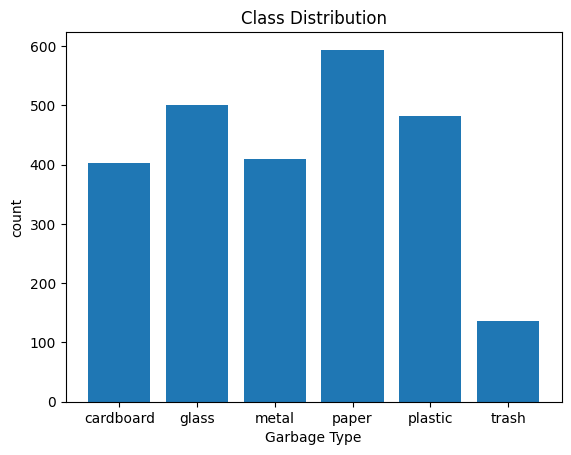

In [80]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts)
plt.title('Class Distribution')
plt.xlabel('Garbage Type')
plt.ylabel('count')
plt.show()

#### Histogram of a sample feature

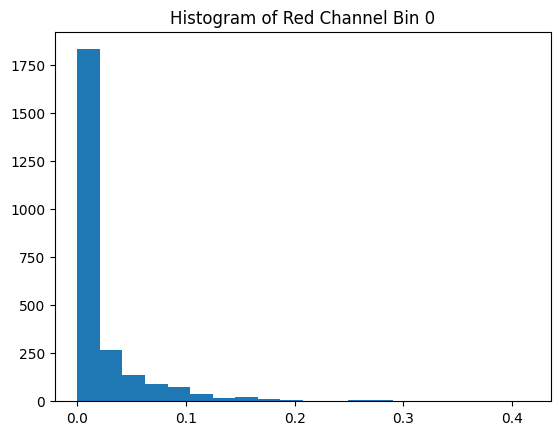

Insights: Shows distribution of low-intensity red pixels across images.


In [81]:
plt.hist(df['hist_r_0'], bins = 20)
plt.title("Histogram of Red Channel Bin 0")
plt.show()
print("Insights: Shows distribution of low-intensity red pixels across images.")

#### Scatter plot of two features colored by class

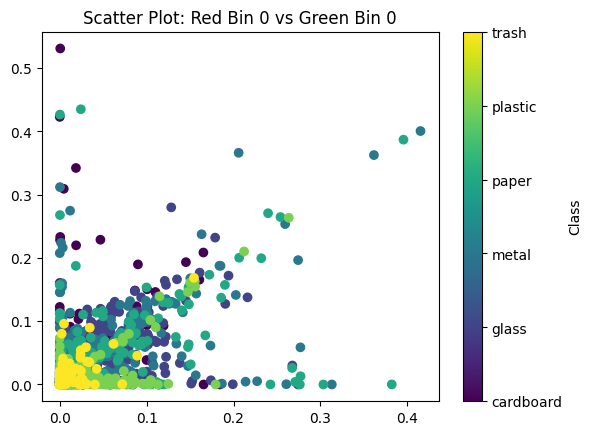

Insights: Some separation by color histograms, -> (glass might have different distributions.)


In [82]:

plt.scatter(X[:, 0], X[:, 8], c=y, cmap='viridis')  # hist_r_0 vs hist_g_0
plt.title('Scatter Plot: Red Bin 0 vs Green Bin 0')
plt.colorbar(ticks=range(len(classes)), label='Class', format=plt.FuncFormatter(lambda x, _: classes[int(x)]))
plt.show()
print("Insights: Some separation by color histograms, -> (glass might have different distributions.)")

#### Correlation Heatmap

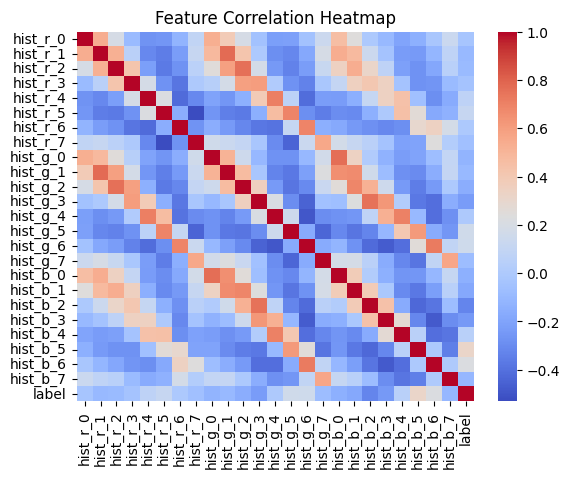

Insights: Identifies correlated histogram bins.


In [84]:
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()
print("Insights: Identifies correlated histogram bins.")

### Model Development

#### KNN

In [85]:
class KNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        preds = []
        for x in X:
            dists = np.linalg.norm(self.X_train - x, axis=1)
            idx = np.argsort(dists)[:self.k]
            votes = self.y_train[idx]
            pred = np.bincount(votes).argmax()
            preds.append(pred)
        return np.array(preds)

# tune k
best_k = 1
best_acc = 0
for k in range(1, 21):
    knn = KNN(k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc = np.mean(preds == y_test)
    print(f"K={k}, Accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Best K: {best_k} with Accuracy: {best_acc:.4f}")

# Train final KNN with best k
knn = KNN(best_k)
knn.fit(X_train, y_train)

K=1, Accuracy=0.6047
K=2, Accuracy=0.5810
K=3, Accuracy=0.6028
K=4, Accuracy=0.5949
K=5, Accuracy=0.5929
K=6, Accuracy=0.6186
K=7, Accuracy=0.6067
K=8, Accuracy=0.6008
K=9, Accuracy=0.6028
K=10, Accuracy=0.6126
K=11, Accuracy=0.5988
K=12, Accuracy=0.6028
K=13, Accuracy=0.5889
K=14, Accuracy=0.5929
K=15, Accuracy=0.5929
K=16, Accuracy=0.5968
K=17, Accuracy=0.5909
K=18, Accuracy=0.5870
K=19, Accuracy=0.5791
K=20, Accuracy=0.5810
Best K: 6 with Accuracy: 0.6186


#### Using Built in(KNN)

In [ ]:

#from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
#from sklearn.neighbors import KNeighborsClassifier
# print("1. Built-in KNN")
# knn_builtin = KNeighborsClassifier(n_neighbors=best_k)  # using your best_k from scratch version
# knn_builtin.fit(X_train, y_train)  # no scaling needed for KNN, but okay to use original
# knn_builtin_pred = knn_builtin.predict(X_test)
# knn_builtin_acc = accuracy_score(y_test, knn_builtin_pred)
# print(f"   Accuracy: {knn_builtin_acc:.4f}")
# print(f"   Confusion Matrix:\n{confusion_matrix(y_test, knn_builtin_pred)}\n")

### Logistic Regression

In [86]:
class LogisticRegressionMulti:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None


    def softmax(self, z):
        # Subtract max for numerical stability
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))  

        
        self.weights = np.random.randn(n_features, n_classes) * 0.01
        self.bias    = np.random.randn(n_classes) * 0.01

       
        y_onehot = np.eye(n_classes)[y]

        losses = []

        for epoch in range(self.epochs):
           
            logits = np.dot(X, self.weights) + self.bias
            probs  = self.softmax(logits)

           
            error = probs - y_onehot  # Gradient
            dw = (1 / n_samples) * np.dot(X.T, error)
            db = (1 / n_samples) * np.sum(error, axis=0)

            
            self.weights -= self.learning_rate * dw
            self.bias    -= self.learning_rate * db

            
            loss = -np.mean(np.sum(y_onehot * np.log(probs + 1e-15), axis=1))   # Loss (cross-entropy)
            losses.append(loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch:4d} | Loss: {loss:.5f}")

        
        plt.plot(losses)
        plt.title("Cross-Entropy Loss (Multi-class)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        probs  = self.softmax(logits)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        logits = np.dot(X, self.weights) + self.bias
        return self.softmax(logits)

#### Using Built in LR

In [ ]:
#from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
#from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print("2. Built-in Logistic Regression")

# lr_builtin = SklearnLogisticRegression(
#     max_iter=1000,
#     solver='lbfgs'
# )

# lr_builtin.fit(X_train_scaled, y_train)
# lr_builtin_pred = lr_builtin.predict(X_test_scaled)

# lr_builtin_acc = accuracy_score(y_test, lr_builtin_pred)

# print(f"   Accuracy: {lr_builtin_acc:.4f}")
# print(f"   Confusion Matrix:\n{confusion_matrix(y_test, lr_builtin_pred)}\n")


### K-means

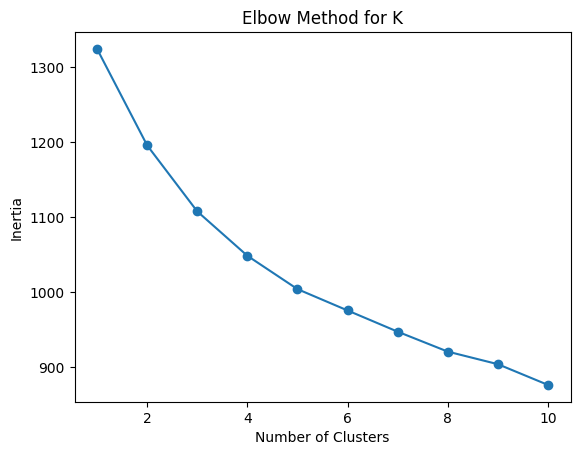

Visualize clusters (using first two features)


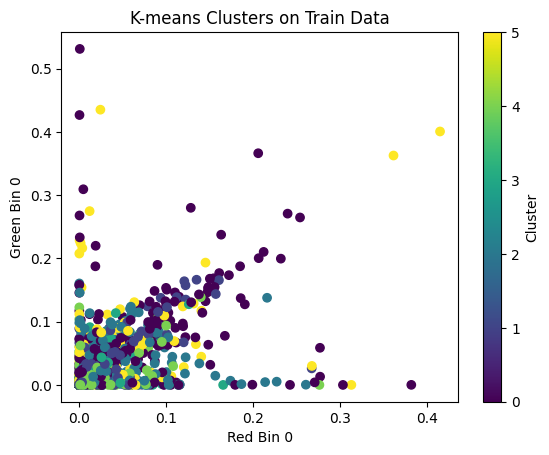

In [87]:
class KMeans:
    def __init__(self, k=3, max_iter=100):
        self.k = k
        self.max_iter = max_iter
    
    def fit(self, X):
        n_samples, _ = X.shape
        self.centroids = X[np.random.choice(n_samples, self.k, replace=False)]
        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] for i in range(self.k)])
            if np.allclose(new_centroids, self.centroids):
                break
            self.centroids = new_centroids
        self.labels_ = labels
        return self.labels_
    
    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    

inertias = []   # Determine number of clusters (elbow method on full X for simplicity)
for k in range(1, 11):
    kmeans = KMeans(k)
    kmeans.fit(X)
    inertia = np.sum(np.min(np.linalg.norm(X[:, np.newaxis] - kmeans.centroids, axis=2), axis=1))
    inertias.append(inertia)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

optimal_k = 6 
kmeans = KMeans(optimal_k)
cluster_labels = kmeans.fit(X_train)  

print("Visualize clusters (using first two features)")
plt.scatter(X_train[:, 0], X_train[:, 8], c=cluster_labels, cmap='viridis')
plt.title('K-means Clusters on Train Data')
plt.xlabel('Red Bin 0')
plt.ylabel('Green Bin 0')
plt.colorbar(label='Cluster')
plt.show()

#### Using built in(KMeans)

In [31]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score
# import numpy as np
# import matplotlib.pyplot as plt

# # ---------- Scaling ----------
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # ---------- Train KMeans ----------
# optimal_k = 6  # number of garbage classes

# kmeans_builtin = KMeans(
#     n_clusters=optimal_k,
#     random_state=42,
#     n_init=10
# )

# cluster_labels = kmeans_builtin.fit_predict(X_scaled)

# # ---------- Map clusters to true labels (Majority Voting) ----------
# cluster_to_label = {}

# for cluster_id in range(optimal_k):
#     true_labels = y[cluster_labels == cluster_id]
#     if len(true_labels) > 0:
#         cluster_to_label[cluster_id] = np.bincount(true_labels).argmax()

# # ---------- Convert cluster IDs → predicted class labels ----------
# y_kmeans_pred = np.array([cluster_to_label[c] for c in cluster_labels])

# # ---------- Accuracy ----------
# kmeans_accuracy = accuracy_score(y, y_kmeans_pred)
# print(f"KMeans Accuracy (after label mapping): {kmeans_accuracy:.4f}")

# plt.scatter(
#     X_scaled[:, 0],   # Red histogram bin 0
#     X_scaled[:, 8],   # Green histogram bin 0
#     c=y_kmeans_pred,
#     cmap='viridis'
# )
# plt.title("KMeans Clustering (Mapped to Class Labels)")
# plt.xlabel("Red Bin 0 (scaled)")
# plt.ylabel("Green Bin 0 (scaled)")
# plt.colorbar(label="Predicted Class")
# plt.show()



### Model Evaluation

#### Compute performance function

In [89]:
def compute_metrics(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] +=1
    
    acc = np.sum(np.diag(cm)) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)
    avg_precision = np.mean(precision[np.isfinite(precision)])
    avg_recall = np.mean(recall[np.isfinite(recall)])
    avg_f1 = np.mean(f1[np.isfinite(f1)])

    return cm, acc, avg_precision, avg_recall, avg_f1

n_classes = len(classes)

#### Evaluate KNN

C:\Users\Parag\AppData\Local\Temp\ipykernel_16644\694223122.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)


K-Means Confusion Matrix:
[[25  4  2 30 10  0]
 [10 23  2 44 28  0]
 [ 7 19 10 42  9  0]
 [ 2  0  2 79 35  0]
 [ 9 16  4 19 51  0]
 [ 4  0  0 16  4  0]]
K-Means Metrics: Accuracy=0.3715, Precision=0.4051, Recall=0.3111, F1=0.3472


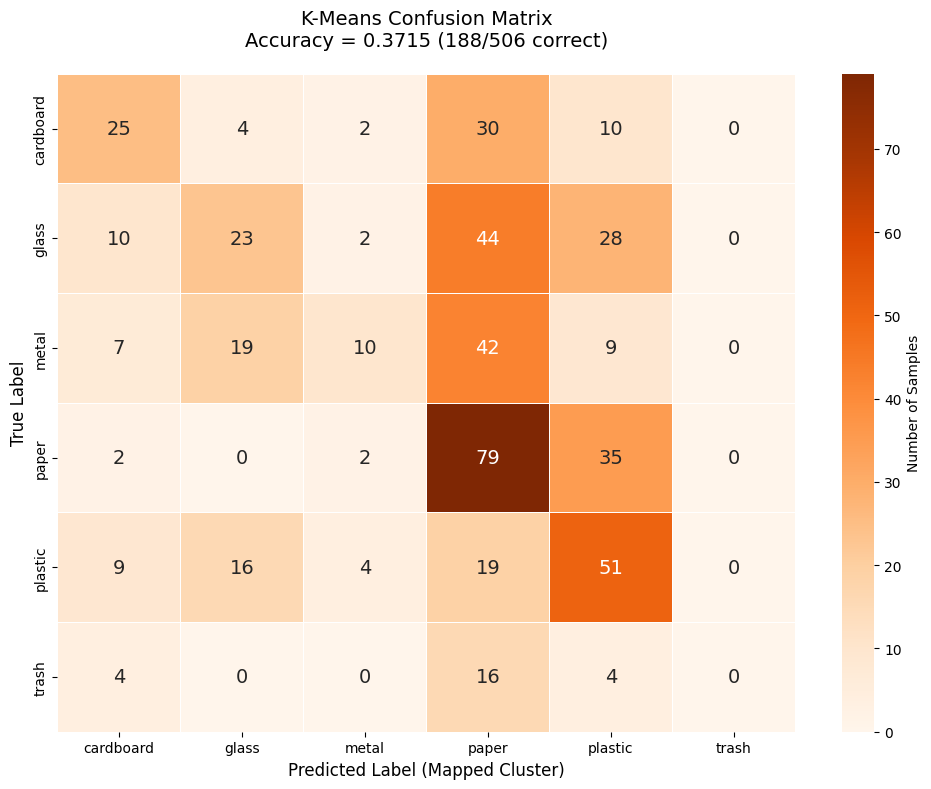

In [ ]:
cluster_to_label = {}

for cid in range(optimal_k):
    mask = (kmeans.labels_ == cid)   # labels_ from TRAIN data
    if np.any(mask):
        cluster_to_label[cid] = np.bincount(y_train[mask]).argmax()

kmeans_test_clusters = kmeans.predict(X_test)

kmeans_preds = np.array([
    cluster_to_label.get(c, 0) for c in kmeans_test_clusters
])

kmeans_cm, kmeans_acc, kmeans_prec, kmeans_rec, kmeans_f1 = compute_metrics(
    y_test, kmeans_preds, n_classes
)

print("K-Means Confusion Matrix:")
print(kmeans_cm)
print(
    f"K-Means Metrics: "
    f"Accuracy={kmeans_acc:.4f}, "
    f"Precision={kmeans_prec:.4f}, "
    f"Recall={kmeans_rec:.4f}, "
    f"F1={kmeans_f1:.4f}"
)

plt.figure(figsize=(10, 8))

sns.heatmap(
    kmeans_cm,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=classes,
    yticklabels=classes,
    linewidths=0.5,
    cbar_kws={'label': 'Number of Samples'},
    annot_kws={"size": 14}
)

plt.xlabel('Predicted Label (Mapped Cluster)', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(
    f'K-Means Confusion Matrix\n'
    f'Accuracy = {kmeans_acc:.4f} '
    f'({int(kmeans_acc * len(y_test))}/{len(y_test)} correct)',
    fontsize=14,
    pad=20
)

plt.tight_layout()
plt.show()


#### Evaluate LR

Epoch    0 | Loss: 1.79335
Epoch  100 | Loss: 1.36274
Epoch  200 | Loss: 1.28873
Epoch  300 | Loss: 1.25443
Epoch  400 | Loss: 1.23444
Epoch  500 | Loss: 1.22133
Epoch  600 | Loss: 1.21206
Epoch  700 | Loss: 1.20516
Epoch  800 | Loss: 1.19983
Epoch  900 | Loss: 1.19559
Epoch 1000 | Loss: 1.19214
Epoch 1100 | Loss: 1.18928
Epoch 1200 | Loss: 1.18687
Epoch 1300 | Loss: 1.18481
Epoch 1400 | Loss: 1.18304


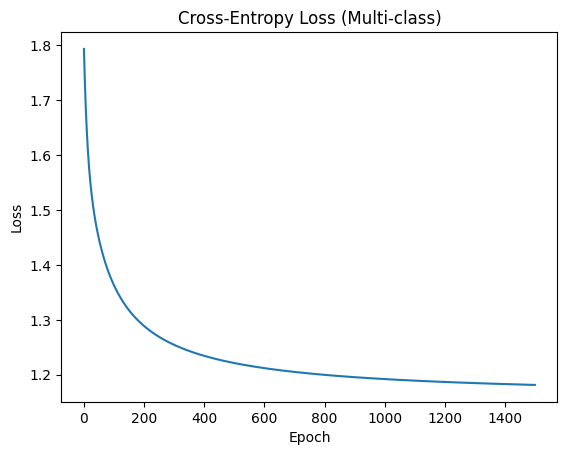


══════════════════════════════════════════════════════════════════════
LOGISTIC REGRESSION (MULTI-CLASS) - TEST PERFORMANCE
══════════════════════════════════════════════════════════════════════
Accuracy            : 0.5198 (263/506)
Macro Avg Precision : 0.5180
Macro Avg Recall    : 0.4704
Macro Avg F1-Score  : 0.4757

Confusion Matrix:
[[46  4  9  7  5  0]
 [ 5 53  3 20 22  4]
 [ 1 26 31 19 10  0]
 [10 20  3 71 14  0]
 [ 6 11  1 21 59  1]
 [ 4  5  2 10  0  3]]


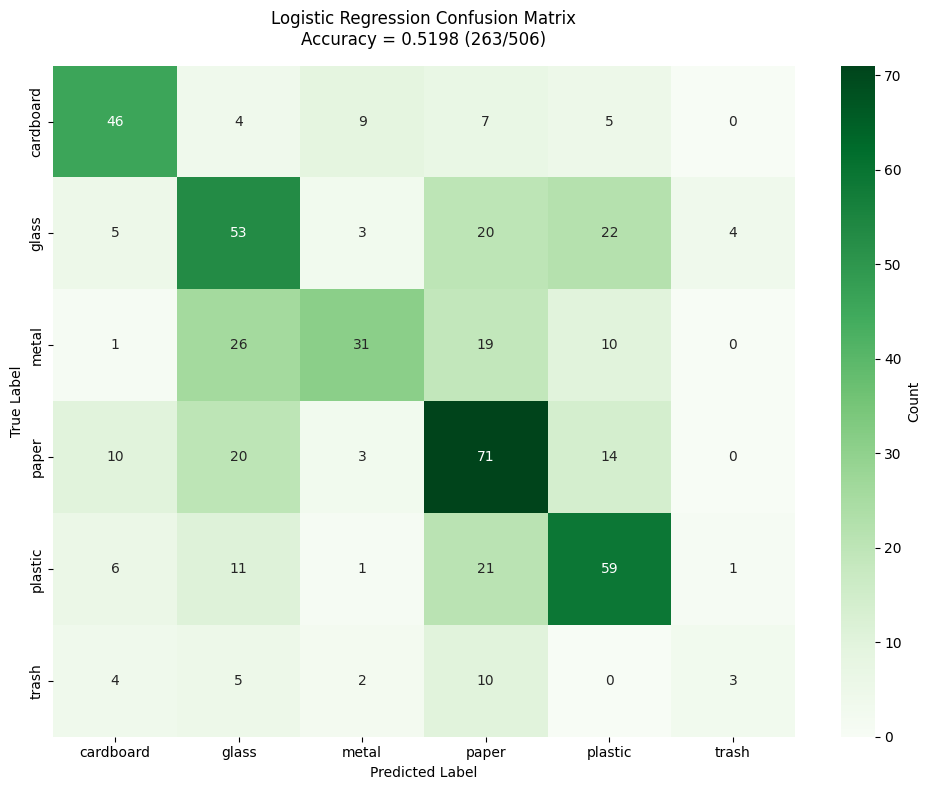

In [92]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
lr = LogisticRegressionMulti(learning_rate=0.05, epochs=1500)
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)



lr_cm, lr_acc, lr_prec, lr_rec, lr_f1 = compute_metrics(
    y_test, lr_preds, n_classes=6
)

print("\n" + "═"*70)
print("LOGISTIC REGRESSION (MULTI-CLASS) - TEST PERFORMANCE")
print("═"*70)
print(f"Accuracy            : {lr_acc:.4f} ({int(lr_acc * len(y_test))}/{len(y_test)})")
print(f"Macro Avg Precision : {lr_prec:.4f}")
print(f"Macro Avg Recall    : {lr_rec:.4f}")
print(f"Macro Avg F1-Score  : {lr_f1:.4f}\n")

print("Confusion Matrix:")
print(lr_cm)

plt.figure(figsize=(10, 8))
sns.heatmap(
    lr_cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=classes,
    yticklabels=classes,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(
    f'Logistic Regression Confusion Matrix\nAccuracy = {lr_acc:.4f} ({int(lr_acc * len(y_test))}/{len(y_test)})',
    pad=15
)
plt.tight_layout()
plt.show()


#### ROC Curve for Logistic Regression

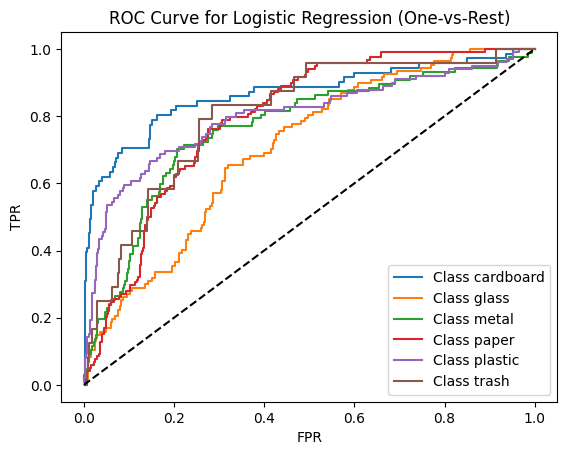

In [94]:
def plot_roc(y_true, probs, class_idx):
    y_bin = (y_true == class_idx).astype(int)
    sorted_idx = np.argsort(-probs[:, class_idx])
    tpr = np.cumsum(y_bin[sorted_idx]) / np.sum(y_bin)
    fpr = np.cumsum(1 - y_bin[sorted_idx]) / np.sum(1 - y_bin)
    plt.plot(fpr, tpr, label=f'Class {classes[class_idx]}')

lr_test_linear = np.dot(X_test, lr.weights) + lr.bias
lr_test_probs = lr.softmax(lr_test_linear)
plt.figure()
for i in range(n_classes):
    plot_roc(y_test, lr_test_probs, i)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Logistic Regression (One-vs-Rest)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

#### Evaluate KMeans Clustering

C:\Users\Parag\AppData\Local\Temp\ipykernel_16644\694223122.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(cm) / np.sum(cm, axis=0)



══════════════════════════════════════════════════════════════════════
K-MEANS (AFTER CLUSTER-TO-LABEL MAPPING) - TEST PERFORMANCE
══════════════════════════════════════════════════════════════════════
Accuracy            : 0.3715 (188/506)
Macro Avg Precision : 0.4051
Macro Avg Recall    : 0.3111
Macro Avg F1-Score  : 0.3472

Confusion Matrix:
[[25  4  2 30 10  0]
 [10 23  2 44 28  0]
 [ 7 19 10 42  9  0]
 [ 2  0  2 79 35  0]
 [ 9 16  4 19 51  0]
 [ 4  0  0 16  4  0]]


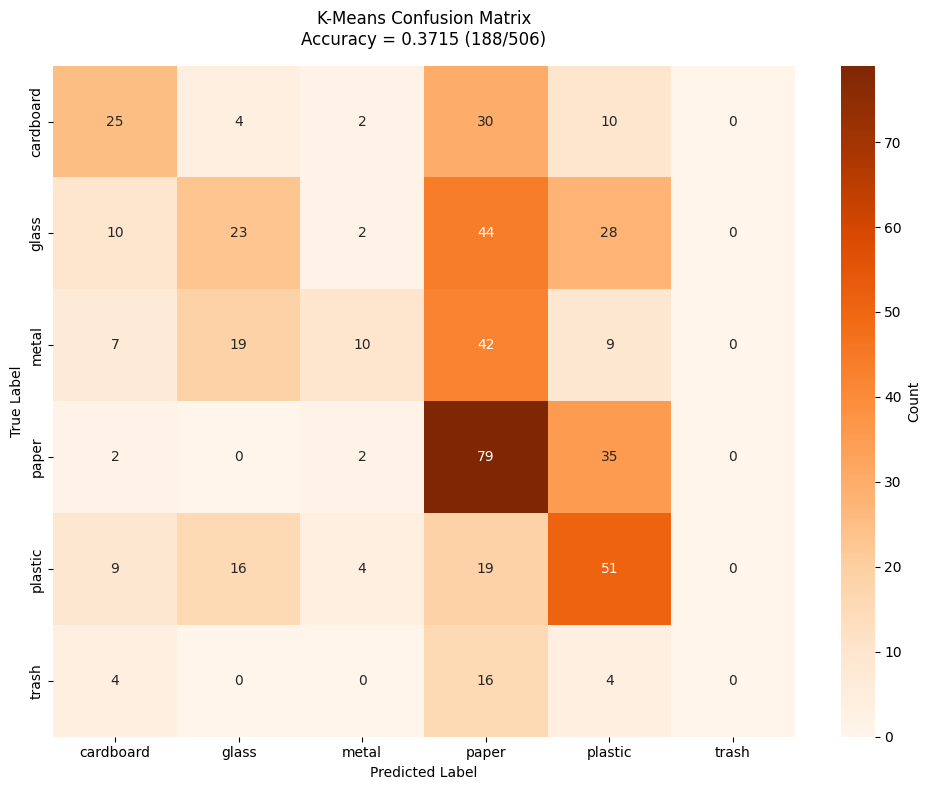

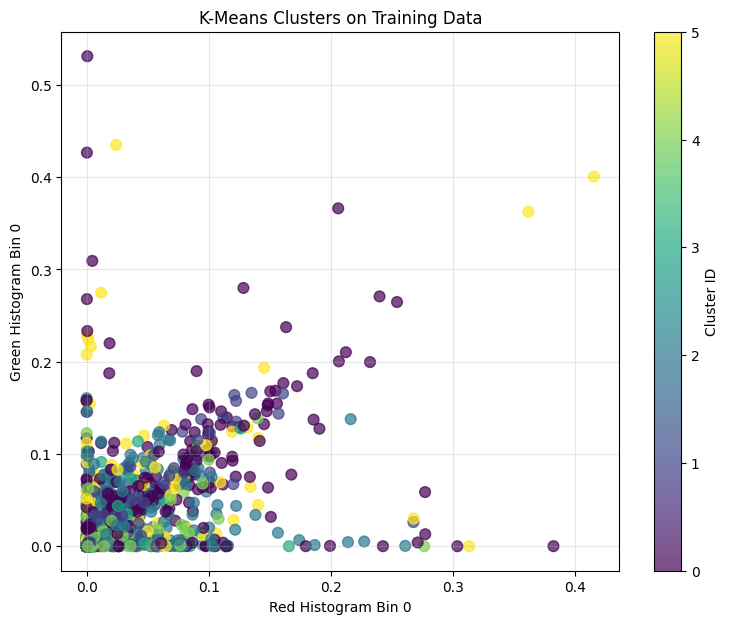

In [95]:
kmeans_trial = KMeans(k=optimal_k)
kmeans_trial.fit(X_train)

cluster_to_label = {}
for cid in range(optimal_k):
    mask = (kmeans_trial.labels_ == cid)
    if np.any(mask):
        cluster_to_label[cid] = np.bincount(y_train[mask]).argmax()

test_clusters = kmeans_trial.predict(X_test)
kmeans_pred_t = np.array([cluster_to_label.get(c, 0) for c in test_clusters])



kmeans_cm, kmeans_acc, kmeans_prec, kmeans_rec, kmeans_f1 = compute_metrics(
    y_test, kmeans_preds, n_classes=6
)

print("\n" + "═"*70)
print("K-MEANS (AFTER CLUSTER-TO-LABEL MAPPING) - TEST PERFORMANCE")
print("═"*70)
print(f"Accuracy            : {kmeans_acc:.4f} ({int(kmeans_acc * len(y_test))}/{len(y_test)})")
print(f"Macro Avg Precision : {kmeans_prec:.4f}")
print(f"Macro Avg Recall    : {kmeans_rec:.4f}")
print(f"Macro Avg F1-Score  : {kmeans_f1:.4f}\n")

print("Confusion Matrix:")
print(kmeans_cm)

plt.figure(figsize=(10, 8))
sns.heatmap(
    kmeans_cm,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=classes,
    yticklabels=classes,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(
    f'K-Means Confusion Matrix\nAccuracy = {kmeans_acc:.4f} ({int(kmeans_acc * len(y_test))}/{len(y_test)})',
    pad=15
)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 7))
plt.scatter(
    X_train[:, 0], X_train[:, 8],
    c=kmeans.labels_, cmap='viridis', alpha=0.7, s=60
)
plt.title('K-Means Clusters on Training Data')
plt.xlabel('Red Histogram Bin 0')
plt.ylabel('Green Histogram Bin 0')
plt.colorbar(label='Cluster ID')
plt.grid(alpha=0.3)
plt.show()


### Hypothesis testing


Trial 1/10 ...
Epoch    0 | Loss: 1.79432
Epoch  100 | Loss: 1.36466
Epoch  200 | Loss: 1.29020
Epoch  300 | Loss: 1.25559
Epoch  400 | Loss: 1.23539
Epoch  500 | Loss: 1.22212
Epoch  600 | Loss: 1.21273
Epoch  700 | Loss: 1.20573
Epoch  800 | Loss: 1.20032
Epoch  900 | Loss: 1.19602
Epoch 1000 | Loss: 1.19251
Epoch 1100 | Loss: 1.18960
Epoch 1200 | Loss: 1.18716
Epoch 1300 | Loss: 1.18507
Epoch 1400 | Loss: 1.18327


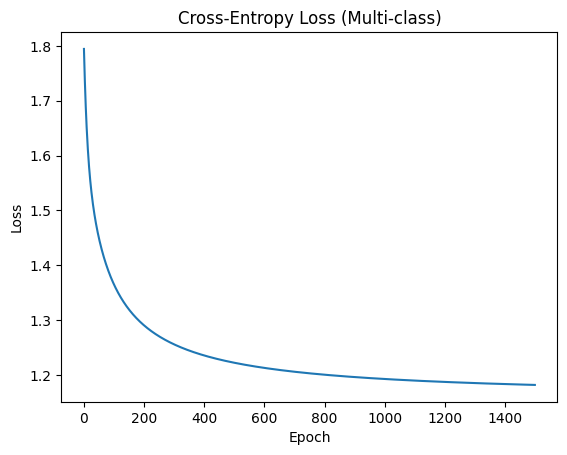


Trial 2/10 ...
Epoch    0 | Loss: 1.79439
Epoch  100 | Loss: 1.37884
Epoch  200 | Loss: 1.30574
Epoch  300 | Loss: 1.27184
Epoch  400 | Loss: 1.25221
Epoch  500 | Loss: 1.23947
Epoch  600 | Loss: 1.23062
Epoch  700 | Loss: 1.22413
Epoch  800 | Loss: 1.21919
Epoch  900 | Loss: 1.21530
Epoch 1000 | Loss: 1.21217
Epoch 1100 | Loss: 1.20959
Epoch 1200 | Loss: 1.20742
Epoch 1300 | Loss: 1.20557
Epoch 1400 | Loss: 1.20397


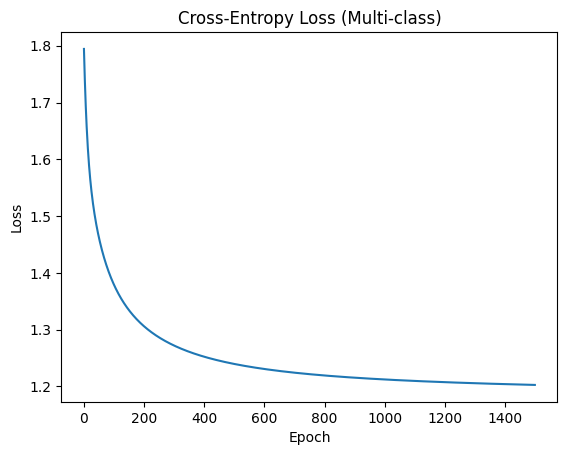


Trial 3/10 ...
Epoch    0 | Loss: 1.78915
Epoch  100 | Loss: 1.38026
Epoch  200 | Loss: 1.30830
Epoch  300 | Loss: 1.27541
Epoch  400 | Loss: 1.25649
Epoch  500 | Loss: 1.24420
Epoch  600 | Loss: 1.23557
Epoch  700 | Loss: 1.22919
Epoch  800 | Loss: 1.22427
Epoch  900 | Loss: 1.22036
Epoch 1000 | Loss: 1.21718
Epoch 1100 | Loss: 1.21455
Epoch 1200 | Loss: 1.21233
Epoch 1300 | Loss: 1.21044
Epoch 1400 | Loss: 1.20882


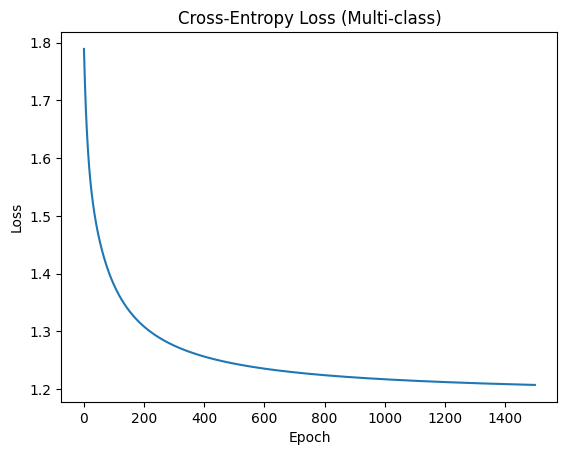


Trial 4/10 ...
Epoch    0 | Loss: 1.79063
Epoch  100 | Loss: 1.38011
Epoch  200 | Loss: 1.30778
Epoch  300 | Loss: 1.27426
Epoch  400 | Loss: 1.25470
Epoch  500 | Loss: 1.24186
Epoch  600 | Loss: 1.23278
Epoch  700 | Loss: 1.22602
Epoch  800 | Loss: 1.22078
Epoch  900 | Loss: 1.21660
Epoch 1000 | Loss: 1.21319
Epoch 1100 | Loss: 1.21035
Epoch 1200 | Loss: 1.20794
Epoch 1300 | Loss: 1.20588
Epoch 1400 | Loss: 1.20410


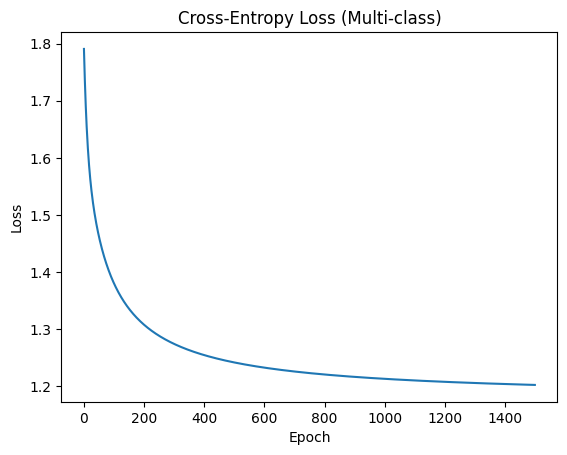


Trial 5/10 ...
Epoch    0 | Loss: 1.78893
Epoch  100 | Loss: 1.38146
Epoch  200 | Loss: 1.30740
Epoch  300 | Loss: 1.27302
Epoch  400 | Loss: 1.25305
Epoch  500 | Loss: 1.24003
Epoch  600 | Loss: 1.23091
Epoch  700 | Loss: 1.22417
Epoch  800 | Loss: 1.21900
Epoch  900 | Loss: 1.21491
Epoch 1000 | Loss: 1.21159
Epoch 1100 | Loss: 1.20885
Epoch 1200 | Loss: 1.20655
Epoch 1300 | Loss: 1.20459
Epoch 1400 | Loss: 1.20290


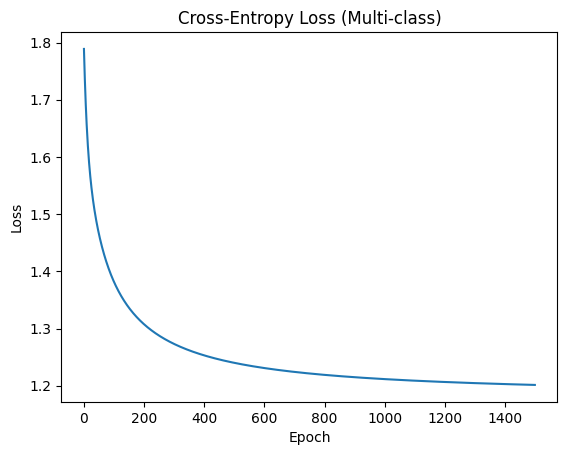


Trial 6/10 ...
Epoch    0 | Loss: 1.79333
Epoch  100 | Loss: 1.38405
Epoch  200 | Loss: 1.31359
Epoch  300 | Loss: 1.28062
Epoch  400 | Loss: 1.26128
Epoch  500 | Loss: 1.24853
Epoch  600 | Loss: 1.23949
Epoch  700 | Loss: 1.23275
Epoch  800 | Loss: 1.22753
Epoch  900 | Loss: 1.22336
Epoch 1000 | Loss: 1.21995
Epoch 1100 | Loss: 1.21712
Epoch 1200 | Loss: 1.21472
Epoch 1300 | Loss: 1.21267
Epoch 1400 | Loss: 1.21090


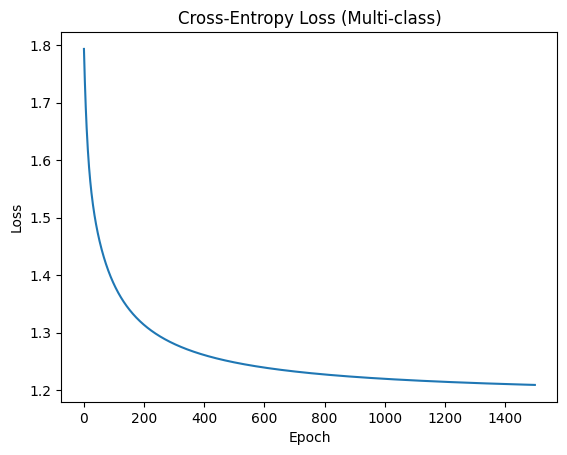


Trial 7/10 ...
Epoch    0 | Loss: 1.80163
Epoch  100 | Loss: 1.37850
Epoch  200 | Loss: 1.30690
Epoch  300 | Loss: 1.27383
Epoch  400 | Loss: 1.25475
Epoch  500 | Loss: 1.24239
Epoch  600 | Loss: 1.23378
Epoch  700 | Loss: 1.22744
Epoch  800 | Loss: 1.22259
Epoch  900 | Loss: 1.21875
Epoch 1000 | Loss: 1.21563
Epoch 1100 | Loss: 1.21304
Epoch 1200 | Loss: 1.21086
Epoch 1300 | Loss: 1.20899
Epoch 1400 | Loss: 1.20738


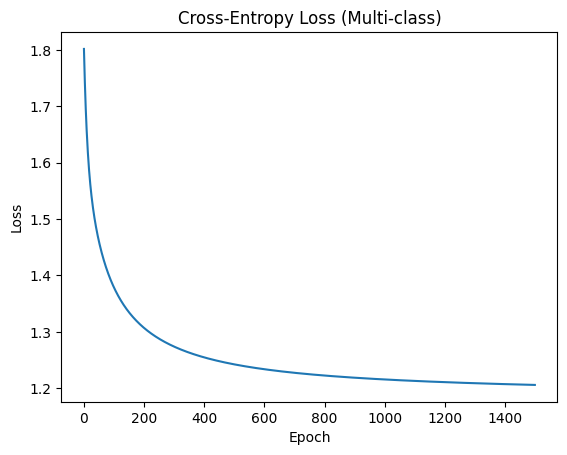


Trial 8/10 ...
Epoch    0 | Loss: 1.79759
Epoch  100 | Loss: 1.38660
Epoch  200 | Loss: 1.31662
Epoch  300 | Loss: 1.28408
Epoch  400 | Loss: 1.26516
Epoch  500 | Loss: 1.25278
Epoch  600 | Loss: 1.24404
Epoch  700 | Loss: 1.23754
Epoch  800 | Loss: 1.23251
Epoch  900 | Loss: 1.22849
Epoch 1000 | Loss: 1.22522
Epoch 1100 | Loss: 1.22249
Epoch 1200 | Loss: 1.22018
Epoch 1300 | Loss: 1.21820
Epoch 1400 | Loss: 1.21648


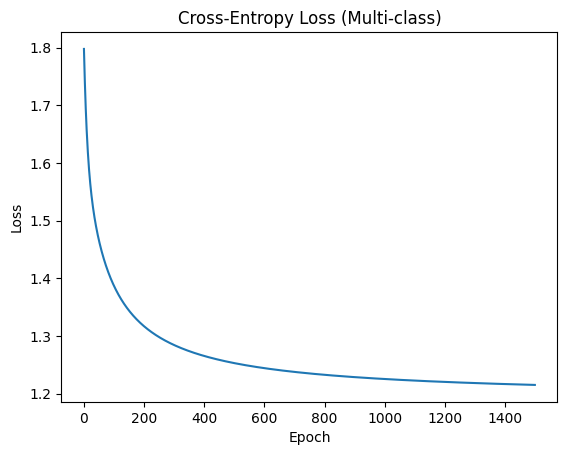


Trial 9/10 ...
Epoch    0 | Loss: 1.79047
Epoch  100 | Loss: 1.37829
Epoch  200 | Loss: 1.30628
Epoch  300 | Loss: 1.27321
Epoch  400 | Loss: 1.25411
Epoch  500 | Loss: 1.24169
Epoch  600 | Loss: 1.23299
Epoch  700 | Loss: 1.22658
Epoch  800 | Loss: 1.22167
Epoch  900 | Loss: 1.21778
Epoch 1000 | Loss: 1.21464
Epoch 1100 | Loss: 1.21203
Epoch 1200 | Loss: 1.20985
Epoch 1300 | Loss: 1.20798
Epoch 1400 | Loss: 1.20638


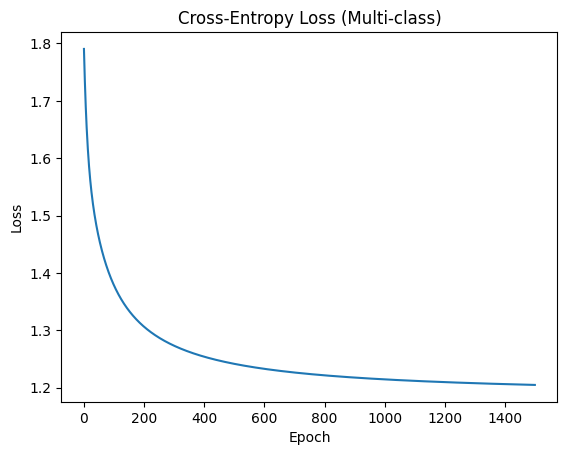


Trial 10/10 ...
Epoch    0 | Loss: 1.79406
Epoch  100 | Loss: 1.38549
Epoch  200 | Loss: 1.31192
Epoch  300 | Loss: 1.27766
Epoch  400 | Loss: 1.25764
Epoch  500 | Loss: 1.24445
Epoch  600 | Loss: 1.23509
Epoch  700 | Loss: 1.22809
Epoch  800 | Loss: 1.22263
Epoch  900 | Loss: 1.21825
Epoch 1000 | Loss: 1.21466
Epoch 1100 | Loss: 1.21165
Epoch 1200 | Loss: 1.20909
Epoch 1300 | Loss: 1.20689
Epoch 1400 | Loss: 1.20497


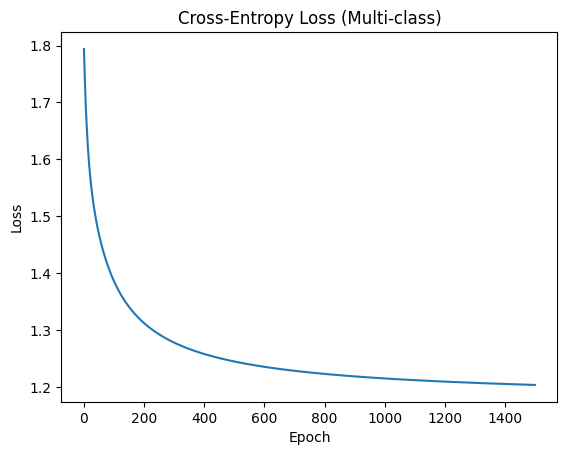


══════════════════════════════════════════════════════════════════════
10-TRIAL STABILITY EVALUATION RESULTS
══════════════════════════════════════════════════════════════════════
KNN    → Mean accuracy: 0.6468 ± 0.0207
LR     → Mean accuracy: 0.5383 ± 0.0124
KMeans → Mean accuracy: 0.3868 ± 0.0226

Interpretation:
• Lower standard deviation = more stable performance across data splits
• Supervised models (KNN, LR) should clearly outperform unsupervised KMeans


In [97]:

def manual_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total if total > 0 else 0.0

n_trials = 10
knn_accs   = []
lr_accs    = []
kmeans_accs = []

for trial in range(n_trials):
    print(f"\nTrial {trial+1}/{n_trials} ...")

    np.random.seed(42 + trial)
    
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
        X, y, test_size=0.2, random_state=42 + trial
    )
    
    # KNN 
    knn_trial = KNN(k=best_k)                     
    knn_trial.fit(X_train_t, y_train_t)
    knn_pred_t = knn_trial.predict(X_test_t)
    acc_knn = manual_accuracy(y_test_t, knn_pred_t)
    knn_accs.append(acc_knn)
    
    # Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_t)
    X_test_scaled  = scaler.transform(X_test_t)
    
    lr_trial = LogisticRegressionMulti(learning_rate=0.05, epochs=1500)
    lr_trial.fit(X_train_scaled, y_train_t)
    lr_pred_t = lr_trial.predict(X_test_scaled)
    acc_lr = manual_accuracy(y_test_t, lr_pred_t)
    lr_accs.append(acc_lr)
    
    # K-Means
    kmeans_trial = KMeans(k=optimal_k)            
    kmeans_trial.fit(X_train_t)    
    cluster_to_label = {}
    for cid in range(optimal_k):
        mask = (kmeans_trial.labels_ == cid)
        if np.sum(mask) > 0:
            cluster_to_label[cid] = np.bincount(y_train_t[mask]).argmax()
  
    test_clusters = kmeans_trial.predict(X_test_t)
    kmeans_pred_t = np.array([cluster_to_label.get(c, 0) for c in test_clusters])
    
    acc_kmeans = manual_accuracy(y_test_t, kmeans_pred_t)
    kmeans_accs.append(acc_kmeans)


print("\n" + "═"*70)
print("10-TRIAL STABILITY EVALUATION RESULTS")
print("═"*70)

print(f"KNN    → Mean accuracy: {np.mean(knn_accs):.4f} ± {np.std(knn_accs):.4f}")
print(f"LR     → Mean accuracy: {np.mean(lr_accs):.4f} ± {np.std(lr_accs):.4f}")
print(f"KMeans → Mean accuracy: {np.mean(kmeans_accs):.4f} ± {np.std(kmeans_accs):.4f}")

print("\nInterpretation:")
print("• Lower standard deviation = more stable performance across data splits")
print("• Supervised models (KNN, LR) should clearly outperform unsupervised KMeans")
